🔍 DEBUGGING DATI PER: sub-NDARAA948VFH_task-movieTP
📂 Caricamento Video Features...
   Video Shape: torch.Size([250, 1280])
📂 Caricamento fMRI Features (NeuroSTORM Output)...
   fMRI Shape: torch.Size([125, 2304])
   📊 fMRI Feature Std Dev: 0.024025

🔗 RISULTATO CORRELAZIONE:
   Miglior Shift (Lag): 9
   (Significato: fMRI[t] corrisponde meglio a Video[t - 9])


/tmp/ipykernel_3410008/2139930113.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  video_data = torch.load(VIDEO_PATH)
/tmp/ipykernel_3410008/2139930113.py:47: FutureWar


✅ Grafico salvato come 'debug_correlation_plot.png'


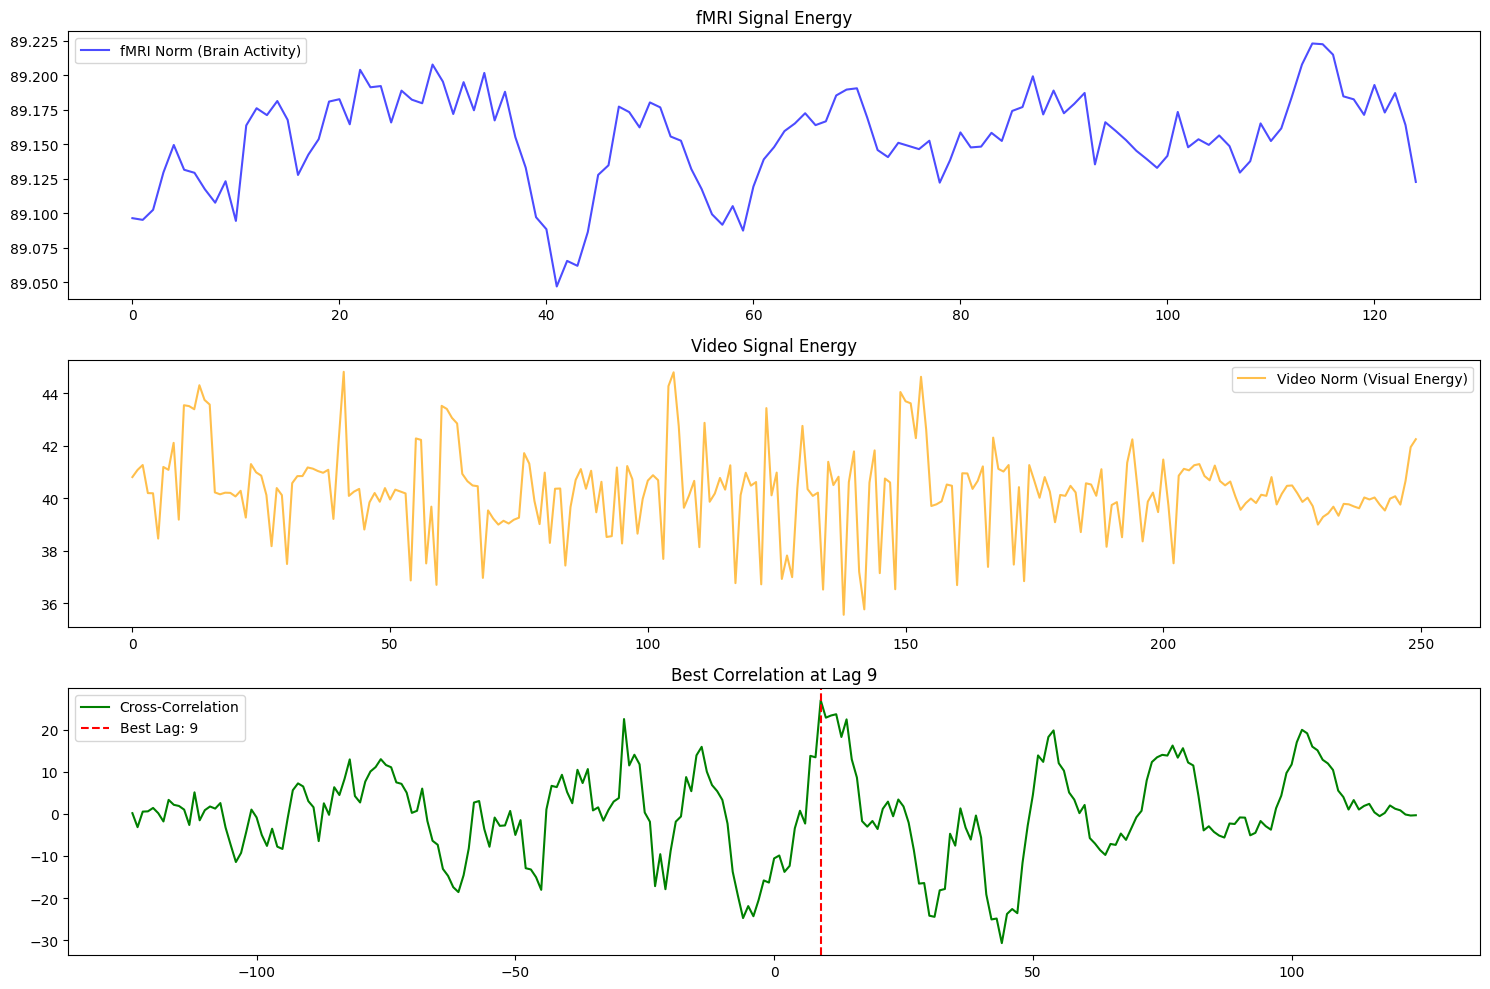

In [2]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.signal import correlate

# === CONFIG ===
SUBJECT = "sub-NDARAA948VFH_task-movieTP" # Usa il soggetto che stavi allenando
FMRI_DIR = f"/home/mfinocchiaro/miccai2026/NeuroSTORM/hbn_data/neurostorm_features_split_50/train/{SUBJECT}"
VIDEO_PATH = "/home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/dataset_fmri_features/features_brain_target_250.pt"

def main():
    print(f"🔍 DEBUGGING DATI PER: {SUBJECT}")
    
    # 1. Carica Feature Video
    print("📂 Caricamento Video Features...")
    if not os.path.exists(VIDEO_PATH):
        print("❌ File Video non trovato!")
        return
    video_data = torch.load(VIDEO_PATH)
    # Usiamo clip_avg come riferimento
    video_feats = video_data['clip_avg'].float() # [Time, 1280]
    video_norms = torch.norm(video_feats.cpu(), dim=1).numpy()
    print(f"   Video Shape: {video_feats.shape}")
    
    # 2. Carica Feature fMRI (NeuroSTORM)
    print("📂 Caricamento fMRI Features (NeuroSTORM Output)...")
    files = sorted(glob.glob(os.path.join(FMRI_DIR, "window_*.pt")), 
                   key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    
    if not files:
        print("❌ Nessun file fMRI trovato!")
        return

    fmri_norms = []
    indices = []
    
    # Prendi un subset per fare prima se sono troppi, ma qui servono tutti per la correlazione
    fmri_matrix = []
    
    for fpath in files:
        idx = int(os.path.basename(fpath).split('_')[1].split('.')[0])
        try:
            # Carica e prendi il frame centrale (10)
            feat = torch.load(fpath, map_location='cpu').float().view(-1, 20)
            center_feat = feat[:, 10] # [2304]
            
            fmri_matrix.append(center_feat)
            fmri_norms.append(torch.norm(center_feat).item())
            indices.append(idx)
        except Exception as e:
            print(f"Errore file {fpath}: {e}")

    fmri_stack = torch.stack(fmri_matrix)
    print(f"   fMRI Shape: {fmri_stack.shape}")
    
    # 3. Analisi Varianza (Il modello è collassato?)
    fmri_std = torch.std(fmri_stack, dim=0).mean().item()
    print(f"   📊 fMRI Feature Std Dev: {fmri_std:.6f}")
    if fmri_std < 0.001:
        print("   ⚠️ ATTENZIONE: Le feature fMRI sono quasi costanti! NeuroSTORM potrebbe aver collassato.")
        return

    # 4. Cross-Correlazione sulle Norme (Energia)
    # L'idea: Se c'è un'esplosione nel video, il cervello dovrebbe attivarsi.
    # Normalizziamo le serie per confrontarle
    v_norm_clean = (video_norms - video_norms.mean()) / video_norms.std()
    f_norm_clean = (np.array(fmri_norms) - np.mean(fmri_norms)) / np.std(fmri_norms)
    
    # Tagliamo alla lunghezza minima comune
    min_len = min(len(v_norm_clean), len(f_norm_clean))
    v_signal = v_norm_clean[:min_len]
    f_signal = f_norm_clean[:min_len]
    
    # Calcolo Cross-Correlazione
    corr = correlate(f_signal, v_signal, mode='full')
    lags = np.arange(-min_len + 1, min_len)
    
    best_lag_idx = np.argmax(corr)
    best_lag = lags[best_lag_idx]
    
    print(f"\n🔗 RISULTATO CORRELAZIONE:")
    print(f"   Miglior Shift (Lag): {best_lag}")
    print(f"   (Significato: fMRI[t] corrisponde meglio a Video[t - {best_lag}])")
    
    # Plot
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(indices, fmri_norms, label="fMRI Norm (Brain Activity)", color='blue', alpha=0.7)
    plt.title("fMRI Signal Energy")
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(video_norms, label="Video Norm (Visual Energy)", color='orange', alpha=0.7)
    plt.title("Video Signal Energy")
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(lags, corr, label="Cross-Correlation", color='green')
    plt.axvline(x=best_lag, color='red', linestyle='--', label=f"Best Lag: {best_lag}")
    plt.title(f"Best Correlation at Lag {best_lag}")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("debug_correlation_plot.png")
    print("\n✅ Grafico salvato come 'debug_correlation_plot.png'")

if __name__ == "__main__":
    main()

In [2]:
import pandas as pd
import numpy as np
import os

# === CONFIGURAZIONE ===
# Percorso del file CBCL originale
CBCL_FILE_PATH = "/home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/metadata/data-2026-02-15T15_51_48.791Z.csv"

# File di output desiderato
OUTPUT_FILE = "labels_3class.csv"

# Soglia clinica per i T-score (65 è il cut-off clinico standard per il CBCL)
CLINICAL_THRESHOLD = 65

def main():
    if not os.path.exists(CBCL_FILE_PATH):
        print(f"❌ Errore: Il file {CBCL_FILE_PATH} non esiste.")
        return

    print(f"📂 Caricamento file CBCL: {CBCL_FILE_PATH}")
    
    # Leggiamo il file saltando la riga 1 (quella che contiene ",assessment","All", ecc.)
    try:
        df_cbcl = pd.read_csv(CBCL_FILE_PATH, skiprows=[1])
    except Exception as e:
        print(f"❌ Errore nella lettura del CSV: {e}")
        return

    print(f"✅ Lette {len(df_cbcl)} righe.")

    # 1. Identificazione Colonne (Usiamo i nomi esatti del tuo file)
    id_col = 'Identifiers'
    ap_col = 'CBCL,CBCL_AP_T'
    ext_col = 'CBCL,CBCL_Ext_T'

    # Controllo di sicurezza
    missing_cols = [col for col in [id_col, ap_col, ext_col] if col not in df_cbcl.columns]
    if missing_cols:
        print(f"❌ Colonne mancanti nel file: {missing_cols}")
        print(f"Colonne disponibili: {df_cbcl.columns.tolist()[:10]}...")
        return

    print(f"🔍 Colonne identificate con successo!")

    results = []

    # 2. Assegnazione delle Classi Cliniche
    for _, row in df_cbcl.iterrows():
        subj_raw = str(row[id_col])
        
        # Pulizia dell'ID (es. "NDARAA075AMK,assessment" diventa "NDARAA075AMK")
        subj_id = subj_raw.split(',')[0].strip()
            
        if not subj_id.startswith('NDAR'):
            continue

        try:
            ap_score = float(row[ap_col])
            ext_score = float(row[ext_col])
        except (ValueError, TypeError):
            # Salta soggetti con dati mancanti (NaN) in queste colonne
            continue

        # LOGICA CLINICA 3 CLASSI:
        if ap_score >= CLINICAL_THRESHOLD:
            if ext_score >= CLINICAL_THRESHOLD:
                label = 2  # ADHD-Combined
                ref_score = max(ap_score, ext_score)
            else:
                label = 1  # ADHD-Inattentive
                ref_score = ap_score
        else:
            label = 0  # Control (o ODD/CD puro non inattentivo)
            ref_score = ap_score

        results.append({
            'subject_id': subj_id,
            'label': label,
            't_score': ref_score
        })

    # 3. Pulizia e Salvataggio
    df_final = pd.DataFrame(results)
    
    if df_final.empty:
        print("❌ Nessun dato valido estratto. Verifica il contenuto del CSV.")
        return
        
    # Gestione duplicati: teniamo l'ultima valutazione se il soggetto compare più volte
    df_final = df_final.drop_duplicates(subset=['subject_id'], keep='last')

    print("\n📊 Distribuzione Classi finale:")
    print("0 (Control):", len(df_final[df_final['label']==0]))
    print("1 (ADHD-I):", len(df_final[df_final['label']==1]))
    print("2 (ADHD-C):", len(df_final[df_final['label']==2]))

    df_final.to_csv(OUTPUT_FILE, index=False)
    print(f"\n✅ File '{OUTPUT_FILE}' generato correttamente.")
    print("Esempio dati:")
    print(df_final.head(3))

if __name__ == "__main__":
    main()

📂 Caricamento file CBCL: /home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/metadata/data-2026-02-15T15_51_48.791Z.csv
✅ Lette 4301 righe.
🔍 Colonne identificate con successo!

📊 Distribuzione Classi finale:
0 (Control): 2594
1 (ADHD-I): 992
2 (ADHD-C): 715

✅ File 'labels_3class.csv' generato correttamente.
Esempio dati:
     subject_id  label  t_score
0  NDARAA075AMK      0     50.0
1  NDARAA117NEJ      0     64.0
2  NDARAA306NT2      1     66.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. SETUP E CARICAMENTO DATI
# ==========================================
# Sostituisci con il percorso reale del tuo file
FILE_PATH = "complete_adhd_stats_3class.csv" 
FILE_PATH="/home/mfinocchiaro/miccai2026/NeuroSTORM/clinical_master_results_3c/complete_adhd_stats.csv"
# FILE_PATH="/home/mfinocchiaro/miccai2026/NeuroSTORM/clinical_master_results_3class/complete_adhd_stats_3class.csv"

try:
    df_main = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"❌ Errore: Il file {FILE_PATH} non è stato trovato.")
    print("Assicurati di essere nella stessa cartella del file o aggiorna il percorso.")
    exit()

print("📊 Dati Caricati con successo.")
print(f"Numero totale di soggetti: {len(df_main)}")

# ==========================================
# FUNZIONE DI VALUTAZIONE (LOO)
# ==========================================
def evaluate_loo(clf, X, y, name):
    loo = LeaveOneOut()
    preds = []
    
    for train_idx, test_idx in loo.split(X):
        # Training sul fold (N-1)
        clf.fit(X[train_idx], y[train_idx])
        # Predizione sull'elemento escluso
        preds.append(clf.predict(X[test_idx])[0])
        
    acc = accuracy_score(y, preds)
    b_acc = balanced_accuracy_score(y, preds) 
    
    return {
        'Model': name, 
        'Total Acc': acc, 
        'Balanced Acc': b_acc,
        'Preds': preds
    }

# ==========================================
# ANALISI 1: MULTICLASSE (3 CLASSI)
# ==========================================
print("\n" + "="*50)
print(" 🔬 ANALISI 1: MULTICLASSE (Control vs ADHD-I vs ADHD-C)")
print("="*50)

# Preparazione dati 3 classi
X_3c = df_main[['ISC']].values
y_3c = df_main['label'].values

print(f"Distribuzione Classi:\n{pd.Series(y_3c).value_counts().sort_index()}")

# Scaliamo la feature ISC
scaler_3c = StandardScaler()
X_3c_scaled = scaler_3c.fit_transform(X_3c)

# Modelli per 3 classi
clf_dummy_3c = DummyClassifier(strategy='most_frequent')
clf_svm_rbf_3c = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Esecuzione
res_dummy_3c = evaluate_loo(clf_dummy_3c, X_3c_scaled, y_3c, "Baseline (Dummy)")
res_rbf_3c = evaluate_loo(clf_svm_rbf_3c, X_3c_scaled, y_3c, "ISC Only (SVM-RBF)")

print("\n--- Risultati 3 Classi ---")
print(f"{res_dummy_3c['Model']:>20}: Bal Acc = {res_dummy_3c['Balanced Acc']*100:.1f}% | Tot Acc = {res_dummy_3c['Total Acc']*100:.1f}%")
print(f"{res_rbf_3c['Model']:>20}: Bal Acc = {res_rbf_3c['Balanced Acc']*100:.1f}% | Tot Acc = {res_rbf_3c['Total Acc']*100:.1f}%")

# Matrice di Confusione 3 Classi
cm_3c = confusion_matrix(y_3c, res_rbf_3c['Preds'], labels=[0, 1, 2])
print("\n--- Matrice di Confusione (SVM-RBF) ---")
print("          Pred: Ctrl | Pred: ADHD-I | Pred: ADHD-C")
print(f"Vero Ctrl   : {cm_3c[0][0]:^10} | {cm_3c[0][1]:^12} | {cm_3c[0][2]:^12}")
print(f"Vero ADHD-I : {cm_3c[1][0]:^10} | {cm_3c[1][1]:^12} | {cm_3c[1][2]:^12}")
print(f"Vero ADHD-C : {cm_3c[2][0]:^10} | {cm_3c[2][1]:^12} | {cm_3c[2][2]:^12}")


# ==========================================
# ANALISI 2: BINARIA (Control vs ADHD Totale)
# ==========================================
print("\n\n" + "="*50)
print(" 🔬 ANALISI 2: BINARIA (Control vs ADHD Totale)")
print("="*50)

# Creiamo una copia del dataframe per non intaccare l'originale
df_bin = df_main.copy()

# Mappatura: Convertiamo l'etichetta 2 (ADHD-C) in 1. 
# Quindi avremo: 0 = Control, 1 = ADHD (Qualsiasi tipo)
df_bin['label'] = df_bin['label'].replace({2: 1})

X_bin = df_bin[['ISC']].values
y_bin = df_bin['label'].values

print(f"Distribuzione Classi:\n{pd.Series(y_bin).value_counts().sort_index()}")

# Scaliamo la feature ISC per l'analisi binaria
scaler_bin = StandardScaler()
X_bin_scaled = scaler_bin.fit_transform(X_bin)

# Modelli per classificazione binaria
clf_dummy_bin = DummyClassifier(strategy='most_frequent')
clf_svm_rbf_bin = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Esecuzione
res_dummy_bin = evaluate_loo(clf_dummy_bin, X_bin_scaled, y_bin, "Baseline (Dummy)")
res_rbf_bin = evaluate_loo(clf_svm_rbf_bin, X_bin_scaled, y_bin, "ISC Only (SVM-RBF)")

print("\n--- Risultati Binari ---")
print(f"{res_dummy_bin['Model']:>20}: Bal Acc = {res_dummy_bin['Balanced Acc']*100:.1f}% | Tot Acc = {res_dummy_bin['Total Acc']*100:.1f}%")
print(f"{res_rbf_bin['Model']:>20}: Bal Acc = {res_rbf_bin['Balanced Acc']*100:.1f}% | Tot Acc = {res_rbf_bin['Total Acc']*100:.1f}%")

# Matrice di Confusione Binaria
cm_bin = confusion_matrix(y_bin, res_rbf_bin['Preds'], labels=[0, 1])
print("\n--- Matrice di Confusione (SVM-RBF) ---")
print("          Pred: Ctrl | Pred: ADHD")
print(f"Vero Ctrl   : {cm_bin[0][0]:^10} | {cm_bin[0][1]:^10}")
print(f"Vero ADHD   : {cm_bin[1][0]:^10} | {cm_bin[1][1]:^10}")

print("\n✅ Analisi completate.")

📊 Dati Caricati con successo.
Numero totale di soggetti: 124

 🔬 ANALISI 1: MULTICLASSE (Control vs ADHD-I vs ADHD-C)
Distribuzione Classi:
0    77
1    26
2    21
Name: count, dtype: int64

--- Risultati 3 Classi ---
    Baseline (Dummy): Bal Acc = 33.3% | Tot Acc = 62.1%
  ISC Only (SVM-RBF): Bal Acc = 33.4% | Tot Acc = 41.9%

--- Matrice di Confusione (SVM-RBF) ---
          Pred: Ctrl | Pred: ADHD-I | Pred: ADHD-C
Vero Ctrl   :     42     |      20      |      15     
Vero ADHD-I :     12     |      2       |      12     
Vero ADHD-C :     8      |      5       |      8      


 🔬 ANALISI 2: BINARIA (Control vs ADHD Totale)
Distribuzione Classi:
0    77
1    47
Name: count, dtype: int64

--- Risultati Binari ---
    Baseline (Dummy): Bal Acc = 50.0% | Tot Acc = 62.1%
  ISC Only (SVM-RBF): Bal Acc = 52.8% | Tot Acc = 53.2%

--- Matrice di Confusione (SVM-RBF) ---
          Pred: Ctrl | Pred: ADHD
Vero Ctrl   :     42     |     35    
Vero ADHD   :     23     |     24    

✅ Analisi 

In [7]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CARICAMENTO E PREPARAZIONE DATI
# ==========================================
print("Caricamento dati...")
stats_df = pd.read_csv('/home/mfinocchiaro/miccai2026/NeuroSTORM/clinical_master_results/complete_adhd_stats.csv')
labels_df = pd.read_csv('/home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/metadata/labels_3class.csv')

# Uniamo i dataset usando il subject_id
# Rimuoviamo la colonna 'label' da stats_df per prendere quella corretta (a 3 classi) da labels_df
merged_df = pd.merge(stats_df.drop(columns=['label']), labels_df[['subject_id', 'label']], on='subject_id', how='inner')

# ==========================================
# 2. DEFINIZIONE DELLE FEATURE E DELLE CLASSI
# ==========================================
# Estrazione delle features
X_all = merged_df[['mean_rank', 'stability', 'engagement', 'ISC']]
X_isc = merged_df[['ISC']]

# Definizione dei target:
# Ternario: 0, 1, 2
y_3class = merged_df['label']

# Binario: 0 vs All (uniamo la classe 1 e 2 nella classe 1)
y_2class = y_3class.replace({2: 1}) 

# Scaliamo le features per standardizzarle (media 0, varianza 1)
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)
X_isc_scaled = scaler.fit_transform(X_isc)

# ==========================================
# 3. FUNZIONE DI VALUTAZIONE E PLOTTING
# ==========================================
def evaluate_and_plot(clf, X, y, title, ax, is_binary=False):
    """
    Esegue la cross_val_predict su tutto il dataset e disegna la matrice di confusione.
    Restituisce anche il Balanced Accuracy Score e il Classification Report.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Previsione su tutti i dati, ma ogni previsione è "out-of-fold" (il modello non ha mai visto il dato in fase di training)
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    
    # Calcolo metriche
    bal_acc = balanced_accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
    # Impostazioni grafiche per la matrice di confusione
    labels = ['0', 'All (1+2)'] if is_binary else ['0', '1', '2']
    cmap = 'Greens' if is_binary else 'Blues'
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{title}\nBal. Acc: {bal_acc:.3f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    
    return bal_acc, classification_report(y, y_pred, zero_division=0)

# ==========================================
# 4. INIZIALIZZAZIONE MODELLI E CREAZIONE GRAFICI
# ==========================================
# Impostiamo class_weight='balanced' per contrastare lo sbilanciamento delle classi
svm_clf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Prepariamo la griglia dei grafici (4 righe, 2 colonne)
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

print("\nCalcolo metriche in corso... (potrebbe richiedere qualche secondo)")

# --- RIGA 0: SVM 3-Classi ---
bal_svm_3_all, rep_svm_3_all = evaluate_and_plot(svm_clf, X_all_scaled, y_3class, "SVM 3-Class (All Feat)", axes[0,0])
bal_svm_3_isc, rep_svm_3_isc = evaluate_and_plot(svm_clf, X_isc_scaled, y_3class, "SVM 3-Class (ISC Only)", axes[0,1])

# --- RIGA 1: SVM Binario (0 vs All) ---
bal_svm_2_all, rep_svm_2_all = evaluate_and_plot(svm_clf, X_all_scaled, y_2class, "SVM 0 vs All (All Feat)", axes[1,0], is_binary=True)
bal_svm_2_isc, rep_svm_2_isc = evaluate_and_plot(svm_clf, X_isc_scaled, y_2class, "SVM 0 vs All (ISC Only)", axes[1,1], is_binary=True)

# --- RIGA 2: Random Forest 3-Classi ---
bal_rf_3_all, rep_rf_3_all = evaluate_and_plot(rf_clf, X_all_scaled, y_3class, "RF 3-Class (All Feat)", axes[2,0])
bal_rf_3_isc, rep_rf_3_isc = evaluate_and_plot(rf_clf, X_isc_scaled, y_3class, "RF 3-Class (ISC Only)", axes[2,1])

# --- RIGA 3: Random Forest Binario (0 vs All) ---
bal_rf_2_all, rep_rf_2_all = evaluate_and_plot(rf_clf, X_all_scaled, y_2class, "RF 0 vs All (All Feat)", axes[3,0], is_binary=True)
bal_rf_2_isc, rep_rf_2_isc = evaluate_and_plot(rf_clf, X_isc_scaled, y_2class, "RF 0 vs All (ISC Only)", axes[3,1], is_binary=True)

# Salvataggio e formattazione dell'immagine
plt.tight_layout()
plt.savefig('full_dataset_cm_results.png')
print("\nGrafico salvato con successo come 'full_dataset_cm_results.png'")

# ==========================================
# 5. STAMPA DEI RISULTATI NUMERICI
# ==========================================
print("\n" + "="*40)
print("=== SVM RESULTS (Balanced Accuracy) ===")
print("="*40)
print(f"SVM 3-Class (All Features): {bal_svm_3_all:.3f}")
print(f"SVM 3-Class (ISC Only)    : {bal_svm_3_isc:.3f}")
print(f"SVM 0 vs All (All Features): {bal_svm_2_all:.3f}")
print(f"SVM 0 vs All (ISC Only)    : {bal_svm_2_isc:.3f}")

print("\n" + "="*40)
print("=== RANDOM FOREST RESULTS (Balanced Acc) ===")
print("="*40)
print(f"RF 3-Class (All Features): {bal_rf_3_all:.3f}")
print(f"RF 3-Class (ISC Only)    : {bal_rf_3_isc:.3f}")
print(f"RF 0 vs All (All Features): {bal_rf_2_all:.3f}")
print(f"RF 0 vs All (ISC Only)    : {bal_rf_2_isc:.3f}")

Caricamento dati...


KeyError: "['mean_rank', 'stability', 'engagement'] not in index"

Caricamento dati...

Calcolo metriche in corso... (potrebbe richiedere qualche secondo)

Grafico salvato con successo come 'full_dataset_cm_results.png'

=== SVM RESULTS (Balanced Accuracy) ===
SVM 3-Class (All Features): 0.429
SVM 3-Class (ISC Only)    : 0.509
SVM 0 vs All (All Features): 0.620
SVM 0 vs All (ISC Only)    : 0.593

=== RANDOM FOREST RESULTS (Balanced Acc) ===
RF 3-Class (All Features): 0.330
RF 3-Class (ISC Only)    : 0.257
RF 0 vs All (All Features): 0.602
RF 0 vs All (ISC Only)    : 0.471


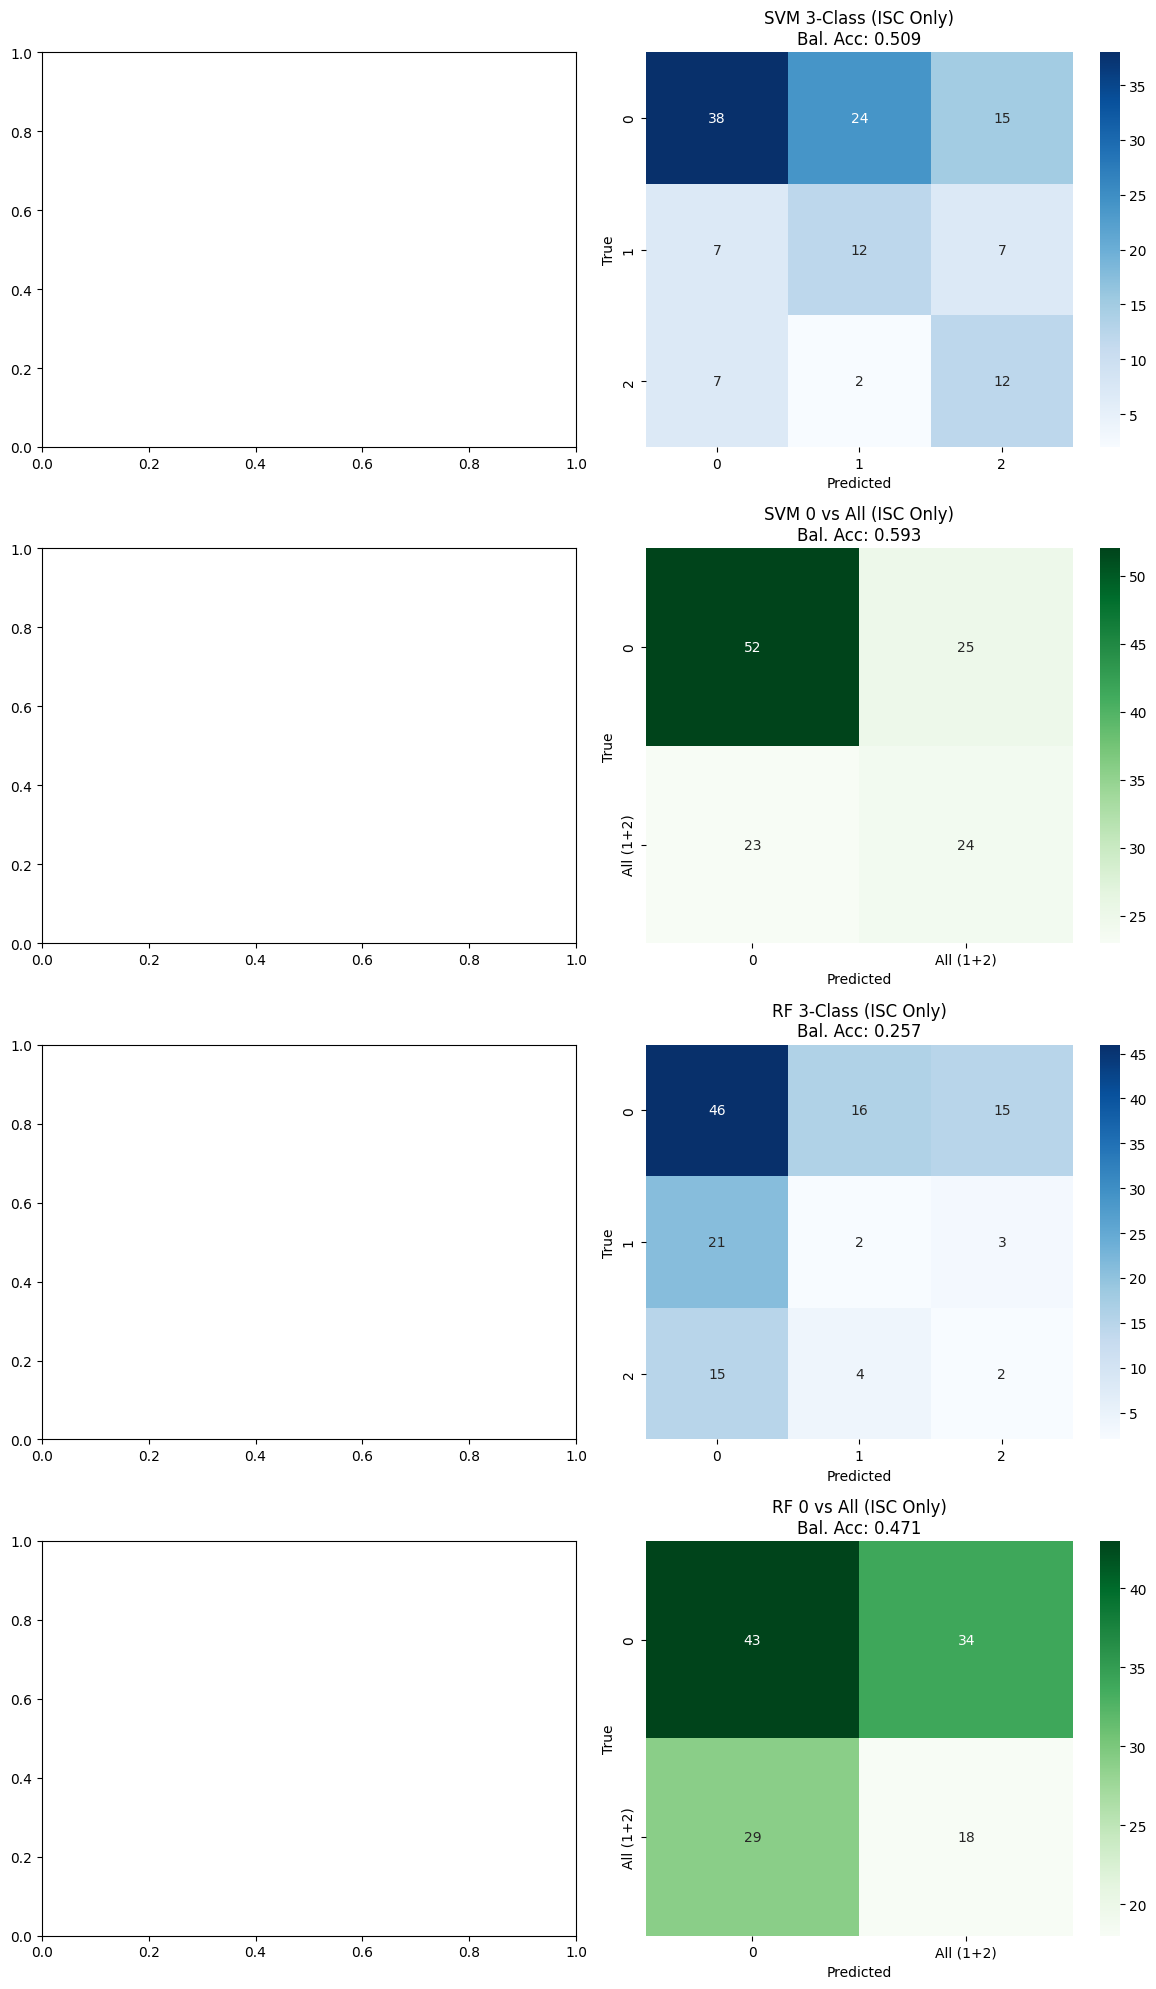

In [10]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CARICAMENTO E PREPARAZIONE DATI
# ==========================================
print("Caricamento dati...")
stats_df = pd.read_csv('/home/mfinocchiaro/miccai2026/NeuroSTORM/isc_results.csv')
labels_df = pd.read_csv('/home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/metadata/labels_3class.csv')

# Uniamo i dataset usando il subject_id
# Rimuoviamo la colonna 'label' da stats_df per prendere quella corretta (a 3 classi) da labels_df
# Normalizza subject_id: da "sub-<ID>_task-..." a "<ID>"
stats_features = stats_df.drop(columns=['label']).copy()
stats_features['subject_id'] = (
    stats_features['subject_id']
    .str.replace(r'^sub-', '', regex=True)
    .str.replace(r'_task-.*$', '', regex=True)
)

merged_df = pd.merge(
    stats_features,
    labels_df[['subject_id', 'label']],
    on='subject_id',
    how='inner'
)

# ==========================================
# 2. DEFINIZIONE DELLE FEATURE E DELLE CLASSI
# ==========================================
# Estrazione delle features
X_isc = merged_df[['isc']]

# Definizione dei target:
# Ternario: 0, 1, 2
y_3class = merged_df['label']

# Binario: 0 vs All (uniamo la classe 1 e 2 nella classe 1)
y_2class = y_3class.replace({2: 1}) 

# Scaliamo le features per standardizzarle (media 0, varianza 1)
scaler = StandardScaler()
X_isc_scaled = scaler.fit_transform(X_isc)

# ==========================================
# 3. FUNZIONE DI VALUTAZIONE E PLOTTING
# ==========================================
def evaluate_and_plot(clf, X, y, title, ax, is_binary=False):
    """
    Esegue la cross_val_predict su tutto il dataset e disegna la matrice di confusione.
    Restituisce anche il Balanced Accuracy Score e il Classification Report.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Previsione su tutti i dati, ma ogni previsione è "out-of-fold" (il modello non ha mai visto il dato in fase di training)
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    
    # Calcolo metriche
    bal_acc = balanced_accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
    # Impostazioni grafiche per la matrice di confusione
    labels = ['0', 'All (1+2)'] if is_binary else ['0', '1', '2']
    cmap = 'Greens' if is_binary else 'Blues'
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{title}\nBal. Acc: {bal_acc:.3f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    
    return bal_acc, classification_report(y, y_pred, zero_division=0)

# ==========================================
# 4. INIZIALIZZAZIONE MODELLI E CREAZIONE GRAFICI
# ==========================================
# Impostiamo class_weight='balanced' per contrastare lo sbilanciamento delle classi
svm_clf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Prepariamo la griglia dei grafici (4 righe, 2 colonne)
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

print("\nCalcolo metriche in corso... (potrebbe richiedere qualche secondo)")

# --- RIGA 0: SVM 3-Classi ---
bal_svm_3_isc, rep_svm_3_isc = evaluate_and_plot(svm_clf, X_isc_scaled, y_3class, "SVM 3-Class (ISC Only)", axes[0,1])

# --- RIGA 1: SVM Binario (0 vs All) ---
bal_svm_2_isc, rep_svm_2_isc = evaluate_and_plot(svm_clf, X_isc_scaled, y_2class, "SVM 0 vs All (ISC Only)", axes[1,1], is_binary=True)

# --- RIGA 2: Random Forest 3-Classi ---
bal_rf_3_isc, rep_rf_3_isc = evaluate_and_plot(rf_clf, X_isc_scaled, y_3class, "RF 3-Class (ISC Only)", axes[2,1])

# --- RIGA 3: Random Forest Binario (0 vs All) ---
bal_rf_2_isc, rep_rf_2_isc = evaluate_and_plot(rf_clf, X_isc_scaled, y_2class, "RF 0 vs All (ISC Only)", axes[3,1], is_binary=True)

# Salvataggio e formattazione dell'immagine
plt.tight_layout()
plt.savefig('full_dataset_cm_results.png')
print("\nGrafico salvato con successo come 'full_dataset_cm_results.png'")

# ==========================================
# 5. STAMPA DEI RISULTATI NUMERICI
# ==========================================
print("\n" + "="*40)
print("=== SVM RESULTS (Balanced Accuracy) ===")
print("="*40)
print(f"SVM 3-Class (All Features): {bal_svm_3_all:.3f}")
print(f"SVM 3-Class (ISC Only)    : {bal_svm_3_isc:.3f}")
print(f"SVM 0 vs All (All Features): {bal_svm_2_all:.3f}")
print(f"SVM 0 vs All (ISC Only)    : {bal_svm_2_isc:.3f}")

print("\n" + "="*40)
print("=== RANDOM FOREST RESULTS (Balanced Acc) ===")
print("="*40)
print(f"RF 3-Class (All Features): {bal_rf_3_all:.3f}")
print(f"RF 3-Class (ISC Only)    : {bal_rf_3_isc:.3f}")
print(f"RF 0 vs All (All Features): {bal_rf_2_all:.3f}")
print(f"RF 0 vs All (ISC Only)    : {bal_rf_2_isc:.3f}")

🎬 Caricamento dati clinici e label sperimentali...
✅ Trovati 4214 soggetti con corrispondenza tra fMRI e Diagnosi Clinica!

📋 TABELLA DI CONTINGENZA: Sottotipi fMRI vs Diagnosi Clinica Reale
Diagnosis_Official      ADHD-Combined Type  ADHD-Hyperactive/Impulsive Type  \
label                                                                         
Control (Label 0)    3                 298                               71   
Subtype 1 (Label 1)  0                 263                               15   
Subtype 2 (Label 2)  1                 262                               24   

Diagnosis_Official   ADHD-Inattentive Type  Acute Stress Disorder  \
label                                                               
Control (Label 0)                      398                      0   
Subtype 1 (Label 1)                    286                      0   
Subtype 2 (Label 2)                    100                      1   

Diagnosis_Official   Adjustment Disorders  Agoraphobia  Alcohol Use

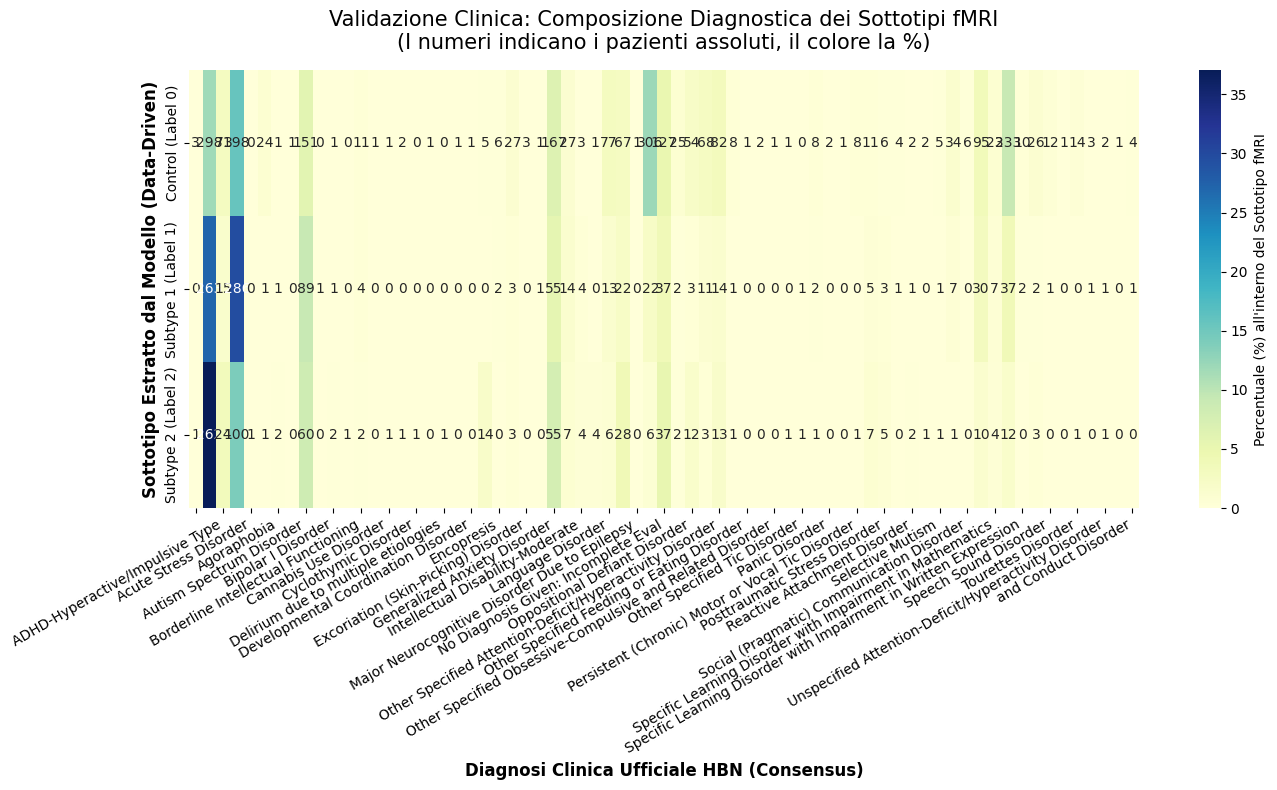

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# === CONFIGURAZIONE ===
METADATA_PATH = "/home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/metadata/labels_3class.csv"
DIAGNOSIS_PATH = "/home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/metadata/diagnosi_cliniche.csv" # Metti qui il nome del tuo nuovo file CSV
OUTPUT_DIR = "miccai_final_results"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# === CONFIGURAZIONE ===
METADATA_PATH = "/home/mfinocchiaro/miccai2026/NeuroSTORM/data/neurostorm_input_4d/metadata/labels_3class.csv"
OUTPUT_DIR = "miccai_final_results"

os.makedirs(OUTPUT_DIR, exist_ok=True)

def parse_clinical_csv(filepath):
    """
    Parser robusto per leggere il CSV clinico che ha un formato di colonne sbilanciato.
    Estrae il primo elemento come ID e l'ultimo come Diagnosi.
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # Saltiamo la prima riga (header) e leggiamo i dati
    for line in lines[1:]:
        line = line.strip()
        if not line: continue
            
        # Dividiamo per virgola
        parts = line.split(',')
        
        # L'ID è sempre la prima cosa prima della prima virgola
        subj_id = parts[0].strip()
        subj_id = subj_id.replace('"', '').strip()  # Rimuoviamo 'sub-' se presente
        
        # La diagnosi è alla fine, togliamo le virgolette se ci sono
        diagnosis = parts[-1].replace('"', '').strip()
        
        data.append({'clean_id': subj_id, 'Diagnosis_Official': diagnosis})
        
    return pd.DataFrame(data)

def main():
    print("🎬 Caricamento dati clinici e label sperimentali...")
    
    # 1. Caricamento Labels Sperimentali (0, 1, 2)
    meta_df = pd.read_csv(METADATA_PATH)
    meta_df['clean_id'] = meta_df['subject_id'].astype(str).str.replace('sub-', '', regex=False).str.strip()
    
    # 2. Caricamento Diagnosi Cliniche con il Parser Robusto
    try:
        diag_df = parse_clinical_csv(DIAGNOSIS_PATH)
    except Exception as e:
        print(f"❌ Errore nel caricamento del file diagnosi: {e}")
        return

    # 3. Merge dei Dataframe
    merged_df = pd.merge(meta_df, diag_df, on='clean_id', how='inner')
    
    print(f"✅ Trovati {len(merged_df)} soggetti con corrispondenza tra fMRI e Diagnosi Clinica!\n")
    
    if len(merged_df) == 0:
        print("⚠️ Nessun soggetto corrispondente! Controlla i file.")
        print(f"Esempio ID fMRI: {meta_df['clean_id'].iloc[0]}")
        print(f"Esempio ID Clinico (pulito): {diag_df['clean_id'].iloc[0]}")
        return

    # 4. Creazione Tabella di Contingenza
    crosstab = pd.crosstab(merged_df['label'], merged_df['Diagnosis_Official'])
    
    # Rinominiamo gli indici
    crosstab.index = crosstab.index.map({0: 'Control (Label 0)', 1: 'Subtype 1 (Label 1)', 2: 'Subtype 2 (Label 2)'})
    
    print("="*90)
    print("📋 TABELLA DI CONTINGENZA: Sottotipi fMRI vs Diagnosi Clinica Reale")
    print("="*90)
    print(crosstab)
    print("="*90)
    
    # 5. Generazione Heatmap
    plt.figure(figsize=(14, 8))
    
    # Percentuali per riga (per capire la composizione del sottotipo)
    crosstab_perc = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    sns.heatmap(crosstab_perc, annot=crosstab, fmt='g', cmap='YlGnBu', 
                cbar_kws={'label': "Percentuale (%) all'interno del Sottotipo fMRI"})
    
    plt.title('Validazione Clinica: Composizione Diagnostica dei Sottotipi fMRI\n(I numeri indicano i pazienti assoluti, il colore la %)', fontsize=15, pad=15)
    plt.ylabel('Sottotipo Estratto dal Modello (Data-Driven)', fontsize=12, fontweight='bold')
    plt.xlabel('Diagnosi Clinica Ufficiale HBN (Consensus)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    
    out_path = os.path.join(OUTPUT_DIR, "clinical_validation_heatmap.png")
    plt.savefig(out_path, dpi=300)
    print(f"\n📊 Heatmap salvata con successo in: {out_path}")

if __name__ == "__main__":
    main()